### Employee Attrition and Performance Analysis

#### importing the required packages

In [ ]:
import pandas as pd
import numpy as np
import pandas
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter

from sklearn import preprocessing
from sklearn.utils import resample
from imblearn import over_sampling as os
from imblearn.over_sampling import SMOTE
from imblearn import pipeline as pl
from imblearn.metrics import (geometric_mean_score,make_index_balanced_accuracy)
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from xgboost.sklearn import XGBClassifier 
from sklearn import model_selection
from sklearn.model_selection import cross_val_score


from sklearn.metrics import auc
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,matthews_corrcoef

#### read in the excel data

In [ ]:
hr_data = pd.read_excel('data/HR-Employee-Attrition.xlsx')

In [ ]:
print(hr_data.shape)
print(hr_data.columns)

In [ ]:
hr_data.head(4)

In [ ]:
pandas.set_option('display.max_columns',None) # set the option to display all the columns of a dataframe....

In [6]:
cols_to_remove = ['EmployeeCount','Over18','StandardHours','EmployeeNumber','JobLevel'] ### remove the unnecessary columns
hr_data = hr_data.drop(hr_data[cols_to_remove],axis=1)
len(hr_data.columns)

30

In [7]:
# creating a list of categorical variables
cat_var = ['BusinessTravel','Department','Education','EducationField','EnvironmentSatisfaction','JobInvolvement','Gender','JobRole','JobSatisfaction',
'MaritalStatus','OverTime','PerformanceRating','RelationshipSatisfaction','WorkLifeBalance','StockOptionLevel']

In [8]:
# converting the object data type to category dtype
for var in cat_var:
    hr_data[var] = hr_data[var].astype('category')

In [9]:
### creating a new dataframe with all categorical descriptions
hr_desc = hr_data.copy()

In [10]:
#### mapping all data with those description so as to analyze
Education_desc = {1 : 'Below College', 2 : 'College' , 3 : 'Bachelor' , 4 : 'Master' , 5 : 'Doctor'}
EnvironmentSatisfaction_desc = {1 : 'Low' , 2 : 'Medium' , 3 : 'High' , 4 : 'Very High'}
JobInvolvement_desc  = {1 : 'Low' , 2 : 'Medium' , 3 : 'High' ,4 : 'Very High'}
JobSatisfaction_desc = {1 : 'Low' , 2 : 'Medium' , 3 : 'High' ,4 : 'Very High'}
PerformanceRating_desc = {1 :'Low' , 2 : 'Good' , 3 : 'Excellent' , 4 : 'Outstanding'}
RelationshipSatisfaction_desc  = {1 : 'Low' , 2 : 'Medium' , 3 : 'High' ,4 : 'Very High'}
WorkLifeBalance_desc = {1 : 'Bad' , 2 : 'Good' , 3 : 'Better' ,4 : 'Best'}


In [11]:
hr_desc['Education'].replace(Education_desc,inplace=True)
hr_desc['EnvironmentSatisfaction'] = hr_desc['EnvironmentSatisfaction'].map(EnvironmentSatisfaction_desc)
hr_desc['JobInvolvement'] = hr_desc['JobInvolvement'].map(JobInvolvement_desc)
hr_desc['JobSatisfaction'] = hr_desc['JobSatisfaction'].map(JobSatisfaction_desc)
hr_desc['PerformanceRating'] = hr_desc['PerformanceRating'].map(PerformanceRating_desc)
hr_desc['RelationshipSatisfaction'] = hr_desc['RelationshipSatisfaction'].map(RelationshipSatisfaction_desc)
hr_desc['WorkLifeBalance'] = hr_desc['WorkLifeBalance'].map(WorkLifeBalance_desc)

In [12]:
obj_cols =hr_desc.select_dtypes(include=['object'])

In [13]:
for var in obj_cols:
    hr_desc[var] = hr_desc[var].astype('category') ### there are 17 categorical columns and 14 int columns

In [14]:
hr_desc.head(3)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,College,Life Sciences,Medium,Female,94,High,Sales Executive,Very High,Single,5993,19479,8,Yes,11,Excellent,Low,0,8,0,Bad,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,Below College,Life Sciences,High,Male,61,Medium,Research Scientist,Medium,Married,5130,24907,1,No,23,Outstanding,Very High,1,10,3,Better,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,College,Other,Very High,Male,92,Medium,Laboratory Technician,High,Single,2090,2396,6,Yes,15,Excellent,Medium,0,7,3,Better,0,0,0,0


In [15]:
del_col = ['DailyRate','MonthlyRate','HourlyRate'] # deleting dailyrate,monthly rate and hourly rate columns 
hr_desc = hr_desc.drop(hr_desc[del_col],axis=1) 

###  Pandas has a function which can turn a categorical variable into a series of zeros and ones, which makes
### them a lot easier to quantify and compare.(get_dummies)

In [16]:
# creating dummies for cat columns   -- one hot encoding  
for var in cat_var:
    cat_list = 'var' + '_' +var
    cat_list = pd.get_dummies(hr_desc[var],prefix=var)
    hr1 =hr_desc.join(cat_list)
    hr_desc = hr1

In [17]:
# creating a list of variables
hr_vars=hr_desc.columns.values.tolist()
to_keep=[i for i in hr_vars if i not in cat_var]
print(len(hr_vars))
print(len(to_keep))
hr_final = hr_desc[to_keep] ## 18 columns dropped as dummies were created for them..
hr_final_vars = hr_final.columns.values.tolist() # creating a list of final variables
hr_final.Attrition = hr_final.Attrition.cat.codes

86
71


C:\Users\Suhasini\Anaconda3\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [18]:
y = hr_final['Attrition']

In [19]:
X = hr_final.drop('Attrition',axis=1) # excluding the target variable Attrition - 70 columns

### normalizing the data before feature selection

### using preprocessing package and Mix Max scaler method

In [20]:
min_max_scaler = preprocessing.MinMaxScaler()

In [21]:
X_scaled = min_max_scaler.fit_transform(X)

In [22]:
df_scaled = pandas.DataFrame(X_scaled)

In [23]:
df_scaled.columns = X.columns


In [24]:
len(df_scaled.columns)

70

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y ,test_size = .3,random_state=12) ### train test split the data first

### Feature Selection
### Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and
### choose either the best or worst performing feature, setting the feature aside and then repeating
### the process with the rest of the features. This process is applied until all features in the dataset are exhausted.
### The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [26]:
xgb = XGBClassifier(n_estimators=100,learning_rate=0.1) ### instantiating a log reg classifier
rfe = RFE(xgb,n_features_to_select=40,step=1)     
rfe = rfe.fit(X_scaled , y)
print(rfe.support_) ### the features selected by RFE
print(rfe.ranking_) ### ranking for various features

[ True  True  True  True  True  True  True  True  True  True  True  True
  True False False  True False False False False False False False  True
 False  True False  True  True  True False  True  True  True False  True
  True False False False  True False False False  True  True  True False
  True False  True False False False  True False False False  True  True
 False  True  True False  True  True  True  True False  True]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  7 26  1 10 13 16 14 17  5 25  1  2
  1 31  1  1  1 24  1  1  1 12  1  1 18  3 20  1 22 23  6  1  1  1  9  1 27
  1  8 30  4  1 28 29 21  1  1 15  1  1 19  1  1  1  1 11  1]


In [27]:
rfe.n_features_

40

In [28]:
### find the columns which has high ranking.... 
cols = df_scaled.loc[:,rfe.support_].columns.tolist()
X = df_scaled[cols]   ### selected features of the model


In [29]:
len(X.columns)

40

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size = .3,random_state=12)

### upsampling technique

In [31]:
print('Original dataset shape {}'.format(Counter(y)))

Original dataset shape Counter({0: 1233, 1: 237})


In [32]:
train_data = X_train
train_data['Attrition'] = y_train

C:\Users\Suhasini\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
len(train_data[train_data.Attrition == 0])

863

In [34]:
### train_data needs to be upsampled...

train_data_majority = train_data[train_data.Attrition == 0]
train_data_minority = train_data[train_data.Attrition==1]



# Upsample minority class
train_data_minority_upsampled = resample(train_data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=863,    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_data_majority, train_data_minority_upsampled])

train_upsampled.Attrition.value_counts()

print("upsampled data   :" , train_upsampled.Attrition.value_counts())

### split the training set again
# Separate input features (X) and target variable (y)
X_train = train_upsampled.drop('Attrition' , axis=1)
y_train = train_upsampled.Attrition


upsampled data   : 1    863
0    863
Name: Attrition, dtype: int64


In [35]:
X_train.columns ### after upsampling

Index(['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'BusinessTravel_Non-Travel',
       'BusinessTravel_Travel_Frequently', 'Department_Research & Development',
       'EducationField_Life Sciences', 'EducationField_Medical',
       'EducationField_Technical Degree', 'EnvironmentSatisfaction_High',
       'EnvironmentSatisfaction_Low', 'EnvironmentSatisfaction_Very High',
       'JobInvolvement_High', 'JobInvolvement_Low', 'JobInvolvement_Very High',
       'Gender_Female', 'JobRole_Laboratory Technician',
       'JobRole_Research Scientist', 'JobRole_Sales Executive',
       'JobRole_Sales Representative', 'JobSatisfaction_Low',
       'JobSatisfaction_Very High', 'OverTime_No',
       'RelationshipSatisfaction_High', 'RelationshipSatisfaction_Low',
       'RelationshipSatisfaction_Very H

In [36]:
# function to evaluate cross validation score for various models
def cross_val_fn(model):
    kFold = model_selection.KFold(n_splits=10,random_state=10)
    scoring = 'accuracy'
    cross_val_results = cross_val_score(model,X_train,y_train,cv =kFold,scoring=scoring)
    return cross_val_results

---------------------------------------------------
Accuracy of Xtreme Gradient Boosting classifier on test set : 0.84
Evaluate Xtreme Gradient Boosting  model : 0.836734693878
Cross Validation Score - 10 Fold    :  0.88
             precision    recall  f1-score   support

          0       0.91      0.89      0.90       370
          1       0.49      0.55      0.52        71

avg / total       0.84      0.84      0.84       441



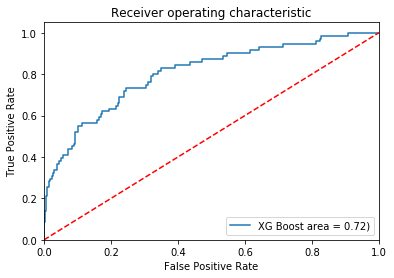

In [44]:
xgb  = XGBClassifier(n_estimators=100,learning_rate=0.1)
xgb_model = xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
    
accuracy = round(xgb.score(X_test,y_test),2)
accu_score = accuracy_score(y_test,y_pred)
class_report = classification_report(y_test,y_pred)
    
print("---------------------------------------------------")
print('Accuracy of Xtreme Gradient Boosting classifier on test set : {:.2f}'.format(xgb.score(X_test,y_test)))
print("Evaluate Xtreme Gradient Boosting  model :" ,accuracy_score(y_test,y_pred))
print("Cross Validation Score - 10 Fold    : " , round((cross_val_fn(xgb).mean()),2) )
print(classification_report(y_test,y_pred))

xgb_roc_auc = roc_auc_score(y_test, xgb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XG Boost area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('xgb_ROC')
plt.show()

  
       

In [45]:
print("ROC-AUC for train and test distributions:",roc_auc_score(y_test, xgb.predict(X_test)))

ROC-AUC for train and test distributions: 0.72059383327


In [47]:
print(matthews_corrcoef(y_test,y_pred))

0.422849253925


In [48]:
y_pred_proba = xgb.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred_proba)

0.80475827940616673

In [49]:
cv_scores = cross_val_score(xgb,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores)

[ 0.96037288  0.94410104  0.97347055  0.94774202  0.96934154]


## Unlike the other metrics discussed above, MCC takes all the cells of the Confusion Matrix into consideration in its formula.
## MCC = TP * TN – FP * FN / √ (TP +FP) * (TP + FN) * (TN + FP) * (TN + FN)
## Similar to Correlation Coefficient, the range of values of MCC lie between -1 to +1

The Matthews correlation coefficient is used in machine learning as a measure of the quality 
of binary (two-class) classifications. It takes into account true and false positives and 
negatives and is generally regarded as a balanced measure which can be used even if the classes 
are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1.
A coefficient of +1 represents a perfect prediction,
0 an average random prediction and -1 an inverse prediction. 

In [ ]:
### xgboost classifier gives a model accuracy of 84%